# Market Risk Project

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Question A (Ex2, part of Q1 and of Q2 of TD1)

### a)  
From the time series of the daily prices of the stock Natixis between January 2015 and December 2016, provided with TD1, estimate a historical VaR on price returns at a one-day horizon for a given probability level (this probability is a parameter which must be changed easily). You must base your VaR on a non-parametric distribution (logistic Kernel, that is $K$ is the derivative of the logistic function $x \mapsto \frac{1}{1 + e^{-x}}$.

In [47]:
df = pd.read_csv("NatixisStock.csv", sep=';')
print(df.shape)

(1023, 2)


We have n days of price data
- We compute daily returns for each of these days

In [48]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df['Price'] = df['Price'].str.replace(',', '.', regex=False).astype(float)
df['Returns']=(df['Price']-df['Price'].shift(1))/df['Price'].shift(1)
df.dropna()

,Date,Price,Returns
1,2015-01-05,5.424,-0.035047
2,2015-01-06,5.329,-0.017515
3,2015-01-07,5.224,-0.019704
4,2015-01-08,5.453,0.043836
5,2015-01-09,5.340,-0.020723
...,...,...,...
1018,2018-12-21,4.045,-0.001481
1019,2018-12-24,4.010,-0.008653
1020,2018-12-27,3.938,-0.017955
1021,2018-12-28,4.088,0.038090


In [49]:
returns = []
k = 1
while df['Date'][k] != pd.to_datetime("02-01-2017", dayfirst=True):
    returns.append((df['Price'][k] - df['Price'][k - 1]) / df['Price'][k - 1])
    k += 1


In [39]:
sample = df[(df['Date'] >= '2016-10-01')&(df['Date']<= '2016-12-31')].copy()
print(sample.head(3))
print(sample.tail(3))

          Date  Price   Returns
449 2016-10-03  4.113 -0.008677
450 2016-10-04  4.223  0.026744
451 2016-10-05  4.340  0.027705
          Date  Price   Returns
510 2016-12-28  5.379 -0.000186
511 2016-12-29  5.328 -0.009481
512 2016-12-30  5.360  0.006006


Kernel density estimators  
Let $X_1,\dots,X_n$ be independent identically distributed random variables that have a probability density $f$ with respect to the Lebesgue measure on $\mathbb{R}$.
The cumulative distribution function is:  
$$F(x) = \int_{-\infty}^x f(t) \, dt$$  

A basic estimator is the moment estimator such that :  
$$E[\mathbf{1}_{\{X \leq x\}}] = F(x)$$  

The empirical cumulative distribution function is given by :  
$$F_n(x) = \frac{1}{n} \sum_{i=1}^n \mathbf{1}_{\{X_i \leq x\}}$$  

By the strong law of large numbers, we have that :
$$F_n(x) \to F(x), \quad \forall x \in \mathbb{R}$$  
almost surely as $n \to \infty$. Therefore, $F_n(x)$ is a consistent estimator of $F(x)$  
for every $x \in \mathbb{R}$. How can we estimate the density $f$? One of the first intuitive  
solutions is based on the following argument. For sufficiently small $h > 0$ we  
can write an approximation  

$$f(x) = \lim_{h \to 0} \frac{F(x + h) - F(x)}{h}$$
$$f(x) \approx \frac{F(x + h) - F(x - h)}{2h}$$ 

Replacing $F$ by the estimate $F_n$, we define  
$$\hat{f}(x) = \frac{F_n(x + h) - F_n(x - h)}{2h}$$  

The function $\hat{f}$ is an estimator of $f$ called the Rosenblatt estimator. We can  
rewrite it in the form :  
$$\hat{f}(x) = \frac{1}{2nh} \sum_{i=1}^n \mathbf{1}_{\{x - h \leq X_i \leq x + h\}} = \frac{1}{nh} \sum_{i=1}^n K_0\left(\frac{X_i - x}{h}\right)$$  
where $K_0(u) = \frac{1}{2} I(-1 \leq u \leq 1)$. A simple generalization of the Rosenblatt estimator is given by  
$$\hat{f}_n(x) = \frac{1}{nh} \sum_{i=1}^n K\left(\frac{X_i - x}{h}\right)$$

__Calculate the VaR based on a non-parametric distribution__


The logistic function is :

\begin{equation}g(x) = \frac{1}{1+e^{-x}}\end{equation}

- $K$ : Kernel function

\begin{equation}K(x) = \frac{e^{-x}}{(1 + e^{-x})^2}\end{equation}

or also :

\begin{equation}K(x) = g(x) \cdot (1 - g(x))\end{equation}

- Then we estimate the CDF with the PDF estimator and after we normalize it
- Last we find the VaR by using the CDF estimator

\begin{equation} VaR_{\alpha\text{ non-parametric}} = \hat{F}^{-1}(\alpha) \end{equation}

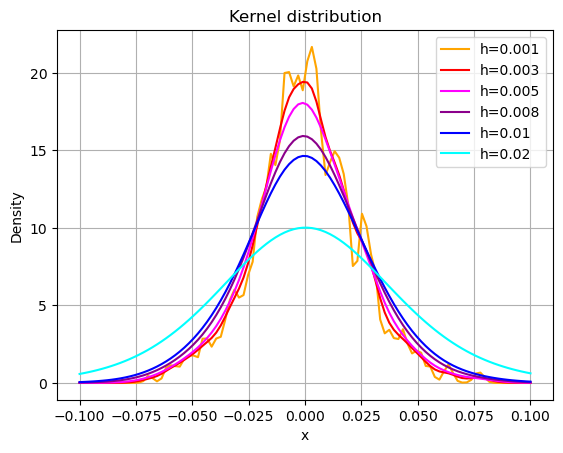

In [40]:
def logistic_function(x):
    return 1 / (1 + np.exp(-x))

def logistic_derivative(x):
    fx = logistic_function(x)
    return fx * (1 - fx)

def kernel_density_estimator(x,tab, h):
    n =len(tab)
    kde = 0
    for i in range(n):
        kde += logistic_derivative((x-tab[i])/h)
    return kde/(n*h)
    
time = np.linspace(-0.1, 0.1, 100)


plt.plot(time, kernel_density_estimator(time, returns, h=0.001), label="h=0.001", color="orange")
plt.plot(time, kernel_density_estimator(time, returns, h=0.003), label="h=0.003", color="red")
plt.plot(time, kernel_density_estimator(time, returns, h=0.005), label="h=0.005", color="magenta")
plt.plot(time, kernel_density_estimator(time, returns, h=0.008), label="h=0.008", color="darkmagenta")
plt.plot(time, kernel_density_estimator(time, returns, h=0.01), label="h=0.01", color="blue")
plt.plot(time, kernel_density_estimator(time, returns, h=0.02), label="h=0.02", color="cyan")

plt.title("Kernel distribution")
plt.legend(loc="best")
plt.xlabel("x")
plt.ylabel("Density")
plt.grid()
plt.show()


In [44]:
def trapezes(f, a, b, n, tab, h):
    pas = (b - a) / n
    integral = 0
    for i in range(1, n):
        integral += f(a + i * pas, tab, h) + f(a + (i + 1) * pas, tab, h)
    return integral * pas / 2

def VaR_non_parametric(alpha,h,tab):
    index = 0
    while trapezes(kernel_density_estimator, -2, index, 1000, tab, h) > alpha :
        index += index - 0.001
    return index

returns_list = sample['Returns'].tolist()
VaR_5_percent = VaR_non_parametric(0.05,0.01,returns_list)
print(VaR_5_percent)

-0.063


### b)  
Which proportion of price returns between January 2017 and December 2018 exceed the VaR threshold defined in the previous question? Do you validate the choice of this non-parametric VaR?

In [45]:
out_sample = df[(df['Date'] >= '2017-01-01')&(df['Date']<= '2018-12-31')].copy()

values =out_sample[out_sample['Returns'] < VaR_5_percent]
proportion = len(values)/len(out_sample['Returns'])

print(proportion

0.00196078431372549


## Question B (Ex2, Q4 of TD2)
We want to calculate the VaR (on the arithmetic variation of price, at a one-day horizon) for a call
option on the Natixis stock. You will implement a Monte-Carlo VaR since the call price is a non-linear
function of the underlying price, that we are able to model thanks to historical data. Here is, in detail,
how you must proceed:
- Estimate the parameters of a standard Brownian motion on the Natixis stock between 2015
and 2018, using an exponential weighting of the data.
- Simulate a number N (say N=1000 or else, but justify your choice for this number) of prices of
the stock in a one-day horizon (we are working at the last date of 2018).
- Transform each of these prices of underlying in prices of the corresponding call (say at the
money, with one-month maturity and 0 risk-free rate and dividend).
- Pick the empirical quantile of these N call prices to build the VaR of the call. 

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df['Price'] = df['Price'].str.replace(',', '.', regex=False).astype(float)
df['Returns']=(df['Price']-df['Price'].shift(1))/df['Price'].shift(1)
df.dropna()

mean = np.mean(df['Returns'])
volatility = np.sqrt(np.mean(np.square(df['Returns']-mean)))

N = 100  # Number of simulations
S0 = df.tail(1)['Price'].values[0]
T = 1 / 252  # One-day horizon (assuming 252 trading days in a year)

np.random.seed(0)
simulated_prices = np.zeros(N)

for i in range(N):
    z = np.random.normal()
    simulated_price = S0 * np.exp((mean - 0.5 * volatility ** 2) * T + volatility * np.sqrt(T) * z)
    simulated_prices[i] = simulated_price

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

K = S0  # Strike price (at-the-money)
T_month = 1 / 12  # One-month maturity
r = 0  # Risk-free rate
sigma = volatility * np.sqrt(252)  # Annualized volatility

call_prices = np.zeros(N)
for i in range(N):
    call_prices[i] = black_scholes_call(simulated_prices[i], K, T_month, r, sigma)

confidence_level = 0.95
empirical_quantile = np.percentile(call_prices, (1 - confidence_level) * 100)
current_call_price = black_scholes_call(S0, K, T_month, r, sigma)
var = current_call_price - empirical_quantile

print(f"Current Call Price: {current_call_price}")
print(f"VaR at {confidence_level * 100}% confidence level: {var}")

## Question C (Ex2, Q1 and Q3 of TD3)
With the dataset provided for TD1 on Natixis prices, first calculate daily returns. You will then analyse
these returns using a specific method in the field of the EVT.
### a)
Estimate the GEV parameters for the two tails of the distribution of returns, using the estimator of
Pickands. What can you conclude about the nature of the extreme gains and losses? 

(PAGE 189) 

Soit (X_n) une suite de variables aléatoires indépendantes identiquement distribuées, de fonction de répartition F appartenant au max-domaine d’attraction d’une loi GEV de paramètre ξ \in \mathbb{R}. Soit k une fonction de \mathbb{N} dans \mathbb{N}. Si

\begin{equation}
\lim_{n \to \infty} k(n) = \infty
\end{equation}

et

\begin{equation}
\lim_{n \to \infty} \frac{k(n)}{n} = 0,
\end{equation}

alors, l’estimateur de Pickands, défini par :

\begin{equation}
\xi_{P_{k(n),n}} = \frac{1}{\log(2)} \log \left( \frac{X_{n-k(n)+1:n} - X_{n-2k(n)+1:n}}{X_{n-2k(n)+1:n} - X_{n-4k(n)+1:n}} \right)
\end{equation}

converge en probabilité vers ξ. De plus, si

\begin{equation}
\lim_{n \to \infty} \frac{k(n)}{\log(\log(n))} = \infty,
\end{equation}

alors la convergence de \xi_{P_{k(n),n}} vers ξ se fait presque sûrement et non pas seulement en probabilité.

In [4]:
def k(n):
    return int(np.log(n))

def pickands_estimator(X):
    n = len(X)
    res = np.log(X['Return_abs'].iloc[n-int(k(n))]-X['Return_abs'].iloc[n-2*k(n)])/(X['Return_abs'].iloc[n-2*k(n)]-X['Return_abs'].iloc[n-4*k(n)])
    return res / np.log(2)

#pickands_value = pickands_estimator(returns)
#print("Estimated GEV parameter (ξ) using Pickands estimator:", pickands_value)
pickands_value = pickands_estimator(df_positifs_sorted)
print("Estimated GEV parameter (ξ) using Pickands estimator:", pickands_value)
pickands_value = pickands_estimator(df_negatifs_sorted)
print("Estimated GEV parameter (ξ) using Pickands estimator:", pickands_value)

Estimated GEV parameter (ξ) using Pickands estimator: -806.9159157427518
Estimated GEV parameter (ξ) using Pickands estimator: -908.068217751631


### b)
Determine the extremal index using the block or run de-clustering. 

In [ ]:
def run_declustering(X, threshold, r):
    n = len(X)
    sum_a = 0
    sum_b = 0
    
    for i in range(n - r + 1):
        window = X[i: i + r]
        if np.all(window > threshold):
            sum_a += 1
    sum_b = np.sum(X > threshold)
    return sum_a / sum_b if sum_b > 0 else 0.0


In [ ]:
def run_declustering(X, threshold, r):
    n = len(X)
    sum_a = sum_b = 0
    for i in range(1, n-r):
        run = X[i:i+r]
        if X[i-1] > threshold:
            sum_b += 1
            if max(run) <= threshold:
                sum_a += 1
    return (sum_a/sum_b)

print(run_declustering(abs(df['Returns']), 0.05, 30))

def pick_up_block (X, r,threshold=0.03):
    max = 0
    block = 0
    for i in range(1, 31):
        if(run_declustering(X, threshold, i)>max):
            max = run_declustering(X, threshold, i)
            block = i
    return block

print(pick_up_block(abs(df['Returns']), 0.05))
print(run_declustering(abs(df['Returns']), 0.03,30))

In [ ]:
def estimate_theta_block(X, u, b):
    X = X.reset_index(drop=True)
    n = len(X)
    k = n // b
    block_extremes = [X[i*b:(i+1)*b].max() for i in range(k)]
    num_clusters = sum(1 for m in block_extremes if m > u)
    num_extremes = sum(1 for x in X if x > u)
    return num_clusters / num_extremes if num_extremes > 0 else 0.0

## Question D (Ex2, Q3 and Q4 of TD4)
With the dataset provided for TD4:
### a) 
Estimate all the parameters of the model of Almgren and Chriss. Is this model well specified?


- Quantité X à liquider par tranches $n_1$, $n_2$, ..., avec $x_k$ = $X$ − $sum(j de 1 à k)$ $n_j$
  
- Trading à temps discret, pas de temps τ ici 1/24 et k de 1 à 24
- Dynamique du prix selon marche aléatoire arithmétique : S_k = S_k−1 + σ(√τ)ε_k − τg(n_k/τ)
, où g est la fonction d’impact permanent, dépendant de la vitesse de liquidation nk/τ entre les instants t_k−1 et t_k .
- Font hypothèse que prix observé est différent de S (dynamique sous-jacente) à cause d’impact transitoire (trader épuise le carnet d’ordre entre t_k−1 et t_k , mais il se reconstitue instantanément en t_k ) : S(barre)_k = S_k−1 − h(n_k /τ ).
- Prix obtenu pour la liquidation (prix initial sans friction + pertes d’illiquidité)

- vol déjà estimée avant
- γ à estimer : g(v) = γv,
- η à estimer : h(nk/τ ) = ξsgn(nk ) + ηnk /τ

In [6]:
df = pd.read_csv("Dataset TD4.csv", sep=';')
print(df.shape)

for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.replace(',', '.', regex=False).astype(float, errors='ignore')

print(df.dtypes)

(1001, 5)
transaction date (1=1day=24 hours)      float64
bid-ask spread                          float64
volume of the transaction (if known)    float64
Sign of the transaction                   int64
Price (before transaction)              float64
dtype: object


__Linear Regression: Method of Least Squares__

$$
y = X\beta + \epsilon
$$

where:
- $y$ is the target variable here it is volume of the transaction (if not known)
- $X$ is the matrix of input features (with a column of ones for the intercept).
- $\beta$ are the model coefficients to estimate.
- $\epsilon$ is the error.

To estimate $\beta$, we minimize the sum of squared errors and the optimal solution is given by:

$$
\hat{\beta} = (X^TX)^{-1}X^Ty
$$

This solution finds the line (or hyperplane) that best fits the data by minimizing the residual errors and we can estimate the volume of the transaction


In [3]:
known = df[df['volume of the transaction (if known)'].notna()]
unknown = df[df['volume of the transaction (if known)'].isna()]

X_known = known[['transaction date (1=1day=24 hours)', 'bid-ask spread','Sign of the transaction', 'Price (before transaction)']].values
y_known = known['volume of the transaction (if known)'].values

X_known = np.c_[np.ones(X_known.shape[0]), X_known]

beta = np.linalg.inv(X_known.T @ X_known) @ X_known.T @ y_known

X_unknown = unknown[['transaction date (1=1day=24 hours)', 'bid-ask spread','Sign of the transaction', 'Price (before transaction)']].values
X_unknown = np.c_[np.ones(X_unknown.shape[0]), X_unknown]

# Faire les prédictions
unknown['volume of the transaction (if known)'] = X_unknown @ beta

df.loc[unknown.index, 'volume of the transaction (if known)'] = unknown['volume of the transaction (if known)']
df['volume of the transaction (if known)'] = (df['volume of the transaction (if known)'].replace(',', '', regex=True).round(0).astype('Int64'))

print("Données avec valeurs estimées :")
print(df.head(5))

Données avec valeurs estimées :
   transaction date (1=1day=24 hours)  bid-ask spread  \
0                            0.000202          0.1100   
1                            0.001070          0.1030   
2                            0.001496          0.1015   
3                            0.003336          0.0920   
4                            0.003952          0.1106   

   volume of the transaction (if known)  Sign of the transaction  \
0                                     8                       -1   
1                                   104                        1   
2                                    86                       -1   
3                                    94                        1   
4                                   110                        1   

   Price (before transaction)  
0                     100.000  
1                      99.984  
2                     100.029  
3                      99.979  
4                     100.060  


/var/folders/pb/7xvj4nhx58l0kys571t39mtm0000gn/T/ipykernel_5267/2011926909.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown['volume of the transaction (if known)'] = X_unknown @ beta


We will compute permanent impact coefficient (𝜆)
This coefficient is related to the long-term change in price (post-execution) due to the trade size. We estimate this through price change relative to volume (since this reflects the persistent effect after the transaction).

In [4]:
prices = df['Price (before transaction)'].values
bid_ask_spread = df['bid-ask spread'].values
signs = df['Sign of the transaction'].values

# Compute transaction-adjusted prices (impact of bid-ask spread)
transaction_prices = prices + (signs * bid_ask_spread / 2)

# 2. Calculate Expected Loss E[X]
expected_loss = np.mean(transaction_prices - prices[0])

# 3. Calculate Variance V[X]
price_variance = np.var(transaction_prices)

# 4. Approximate Lambda (risk aversion parameter)
# Assuming we vary E[X] and V[X] slightly to approximate ΔE[X] and ΔV[X]
# Small perturbation in bid-ask spread to simulate change
epsilon = 0.001
perturbed_transaction_prices = prices + (signs * (bid_ask_spread + epsilon) / 2)

perturbed_expected_loss = np.mean(perturbed_transaction_prices - prices[0])
perturbed_variance = np.var(perturbed_transaction_prices)

# Compute changes ΔE[X] and ΔV[X]
delta_e = perturbed_expected_loss - expected_loss
delta_v = perturbed_variance - price_variance

lambda_value = delta_e / delta_v
print(f"Risk aversion parameter (lambda): {lambda_value:.6f}")
    
# Display key results
print(f"Expected Loss E[X]: {expected_loss:.6f}")
print(f"Variance V[X]: {price_variance:.6f}")
print(f"Perturbed E[X]: {perturbed_expected_loss:.6f}")
print(f"Perturbed V[X]: {perturbed_variance:.6f}")

Risk aversion parameter (lambda): -0.015336
Expected Loss E[X]: -0.201636
Variance V[X]: 0.191319
Perturbed E[X]: -0.201637
Perturbed V[X]: 0.191351


In [110]:
def numerical_second_derivative(df, h=1e-2):
    """
    Estimate second derivative for risk-neutral density q(ST).
    """
    strikes = df['strike'].values
    prices = df['option_price'].values
    
    # Container for second derivatives
    second_derivatives = np.zeros(len(strikes))
    
    # Compute second derivative numerically
    for i in range(1, len(strikes) - 1):
        second_derivatives[i] = (
            (prices[i + 1] - 2 * prices[i] + prices[i - 1]) / ((strikes[i] - strikes[i - 1])**2)
        )
        
    # Set boundary conditions (zeros for simplicity)
    second_derivatives[0] = second_derivatives[-1] = 0
    
    df['q_ST'] = np.exp(0.05) * second_derivatives  # Risk-neutral density
    return df

# Apply numerical differentiation to estimate q(S_T)
data = numerical_second_derivative(data)
print(data)

# Step 2: CRRA Utility Function
def CRRA_utility(ST, gamma):
    """
    CRRA utility function.
    """
    if gamma == 1:
        return np.log(ST)
    else:
        return (ST**(1 - gamma)) / (1 - gamma)

# Step 3: Stochastic Discount Factor ζ(S_T)
def stochastic_discount_factor(ST, St, gamma, lambda_):
    """
    Compute the stochastic discount factor ζ(S_T).
    """
    return lambda_ * (CRRA_utility(ST, gamma) / CRRA_utility(St, gamma))

# Step 4: Physical Density (p) and λ Optimization
def physical_density(q, ST, St, gamma, lambda_):
    """
    Compute physical density using the relationship between p and q.
    """
    return lambda_ * q * (CRRA_utility(ST, gamma) / CRRA_utility(St, gamma))

def calibrate_lambda(data, St, gamma):
    """
    Find the value of λ that optimizes the fit of p.
    """
    def loss_function(lambda_, data, St, gamma):
        # Compute the physical density
        q = data['q_ST'].values
        strikes = data['strike'].values
        p = physical_density(q, strikes, St, gamma, lambda_)
        
        # Return a basic loss function (negative log-likelihood, simplified)
        return -np.sum(np.log(np.maximum(p, 1e-10)))
    
    # Grid search for simplicity (replace with more sophisticated optimization if needed)
    lambda_grid = np.linspace(0.1, 10, 100)  # Test λ in a reasonable range
    losses = [loss_function(lmb, data, St, gamma) for lmb in lambda_grid]
    optimal_lambda = lambda_grid[np.argmin(losses)]
    
    return optimal_lambda

# Example usage with sample data
gamma = 2  # Risk aversion coefficient
St = 100  # Current stock price (same as central strike here)

# Calibrate λ
lambda_optimal = calibrate_lambda(data, St, gamma)
print(f"Optimal λ: {lambda_optimal}")

      transaction date (1=1day=24 hours)  bid-ask spread  \
951                             0.916301          0.0785   
952                             0.916762          0.1096   
953                             0.917134          0.1041   
954                             0.917271          0.1120   
955                             0.918184          0.0938   
956                             0.918653          0.1088   
957                             0.923078          0.0810   
958                             0.929094          0.1024   
959                             0.930431          0.1191   
960                             0.931346          0.0919   
961                             0.937891          0.1073   
962                             0.939040          0.0954   
963                             0.939135          0.0971   
964                             0.939394          0.1136   
965                             0.940877          0.0919   
966                             0.941640

### b) 
In the framework of Almgren and Chriss, what is your liquidation strategy (we recall that you can
only make transactions once every hour). 

## Question E (Q2 and Q3 of TD5)

### b)
Calculate the Hurst exponent of GBPEUR, SEKEUR, and CADEUR. Determine their annualized
volatility using the daily volatility and Hurst exponents. 


In [46]:
df = pd.read_csv("Dataset TD5.csv", delimiter=';', skiprows=1)
print(df.shape)
print(df.dtypes)

(12929, 11)
Date           object
HIGH           object
LOW            object
Unnamed: 3    float64
Date.1         object
HIGH.1         object
LOW.1          object
Unnamed: 7    float64
Date.2         object
HIGH.2         object
LOW.2          object
dtype: object


In [47]:
df.columns = ['Date_GBPEUR', 'High_GBPEUR', 'Low_GBPEUR', 'NaN1', 'Date_SEKEUR', 'High_SEKEUR', 'Low_SEKEUR', 'NaN2', 'Date_CADEUR', 'High_CADEUR', 'Low_CADEUR']

df_cleaned = df.drop(columns=['NaN1', 'NaN2'])

df_cleaned['Date_GBPEUR'] = pd.to_datetime(df_cleaned['Date_GBPEUR'], format='%d/%m/%Y %H:%M', errors='coerce')
df_cleaned['Date_SEKEUR'] = pd.to_datetime(df_cleaned['Date_SEKEUR'], format='%d/%m/%Y %H:%M', errors='coerce')
df_cleaned['Date_CADEUR'] = pd.to_datetime(df_cleaned['Date_CADEUR'], format='%d/%m/%Y %H:%M', errors='coerce')

for col in df_cleaned.select_dtypes(include=['object']).columns:
    df_cleaned[col] = df_cleaned[col].str.replace(',', '.', regex=False).astype(float, errors='ignore')

df = df_cleaned.copy()

print(df.head())

          Date_GBPEUR  High_GBPEUR  Low_GBPEUR         Date_SEKEUR  \
0 2016-03-07 09:00:00       1.2932      1.2917 2016-03-07 09:00:00   
1 2016-03-07 09:15:00       1.2940      1.2930 2016-03-07 09:15:00   
2 2016-03-07 09:30:00       1.2943      1.2922 2016-03-07 09:30:00   
3 2016-03-07 09:45:00       1.2930      1.2913 2016-03-07 09:45:00   
4 2016-03-07 10:00:00       1.2931      1.2921 2016-03-07 10:00:00   

   High_SEKEUR  Low_SEKEUR         Date_CADEUR  High_CADEUR  Low_CADEUR  
0      0.10725     0.10720 2016-03-07 09:00:00       0.6842      0.6829  
1      0.10728     0.10717 2016-03-07 09:15:00       0.6849      0.6841  
2      0.10726     0.10719 2016-03-07 09:30:00       0.6844      0.6837  
3      0.10728     0.10721 2016-03-07 09:45:00       0.6844      0.6839  
4      0.10725     0.10719 2016-03-07 10:00:00       0.6840      0.6835  


In [48]:
df["PRICE_GBPEUR"]=(df["High_GBPEUR"]+df["Low_GBPEUR"])/2
df["PRICE_SEKEUR"]=(df["High_SEKEUR"]+df["Low_SEKEUR"])/2
df["PRICE_CADEUR"]=(df["High_CADEUR"]+df["Low_CADEUR"])/2
df.head()

,Date_GBPEUR,High_GBPEUR,Low_GBPEUR,Date_SEKEUR,High_SEKEUR,Low_SEKEUR,Date_CADEUR,High_CADEUR,Low_CADEUR,PRICE_GBPEUR,PRICE_SEKEUR,PRICE_CADEUR
0,2016-03-07 09:00:00,1.2932,1.2917,2016-03-07 09:00:00,0.10725,0.10720,2016-03-07 09:00:00,0.6842,0.6829,1.29245,0.107225,0.68355
1,2016-03-07 09:15:00,1.2940,1.2930,2016-03-07 09:15:00,0.10728,0.10717,2016-03-07 09:15:00,0.6849,0.6841,1.29350,0.107225,0.68450
2,2016-03-07 09:30:00,1.2943,1.2922,2016-03-07 09:30:00,0.10726,0.10719,2016-03-07 09:30:00,0.6844,0.6837,1.29325,0.107225,0.68405
3,2016-03-07 09:45:00,1.2930,1.2913,2016-03-07 09:45:00,0.10728,0.10721,2016-03-07 09:45:00,0.6844,0.6839,1.29215,0.107245,0.68415
4,2016-03-07 10:00:00,1.2931,1.2921,2016-03-07 10:00:00,0.10725,0.10719,2016-03-07 10:00:00,0.6840,0.6835,1.29260,0.107220,0.68375


In [61]:
import math
def momentum_hurst(price):
    price=pd.DataFrame(price)
    M2=np.nansum(((price-price.shift())**2)[1::1])/len(price)
    M2p=np.nansum(((price-price.shift(2))**2)[2::2])/len(price)*2
    H=math.log(M2p/M2,2)/2
    return H

In [62]:
H_GBP=momentum_hurst(df["PRICE_GBPEUR"])
H_SEK=momentum_hurst(df["PRICE_SEKEUR"])
H_CAD=momentum_hurst(df["PRICE_CADEUR"])

In [63]:
print("H GBP:",H_GBP)
print("H SEK:",H_SEK)
print("H CAD:",H_CAD)

H GBP: 0.6714143303551515
H SEK: 0.6545913434210177
H CAD: 0.6552439913405976


In [64]:
def ret(price):
    return (price-price.shift())/price.shift()
df["RET_GBPEUR"]=ret(df["PRICE_GBPEUR"])
df["RET_SEKEUR"]=ret(df["PRICE_SEKEUR"])
df["RET_CADEUR"]=ret(df["PRICE_CADEUR"])
df.head()

,Date_GBPEUR,High_GBPEUR,Low_GBPEUR,Date_SEKEUR,High_SEKEUR,Low_SEKEUR,Date_CADEUR,High_CADEUR,Low_CADEUR,PRICE_GBPEUR,PRICE_SEKEUR,PRICE_CADEUR,RET_GBPEUR,RET_SEKEUR,RET_CADEUR
0,2016-03-07 09:00:00,1.2932,1.2917,2016-03-07 09:00:00,0.10725,0.10720,2016-03-07 09:00:00,0.6842,0.6829,1.29245,0.107225,0.68355,NaN,NaN,NaN
1,2016-03-07 09:15:00,1.2940,1.2930,2016-03-07 09:15:00,0.10728,0.10717,2016-03-07 09:15:00,0.6849,0.6841,1.29350,0.107225,0.68450,0.000812,0.000000e+00,0.001390
2,2016-03-07 09:30:00,1.2943,1.2922,2016-03-07 09:30:00,0.10726,0.10719,2016-03-07 09:30:00,0.6844,0.6837,1.29325,0.107225,0.68405,-0.000193,-1.294268e-16,-0.000657
3,2016-03-07 09:45:00,1.2930,1.2913,2016-03-07 09:45:00,0.10728,0.10721,2016-03-07 09:45:00,0.6844,0.6839,1.29215,0.107245,0.68415,-0.000851,1.865237e-04,0.000146
4,2016-03-07 10:00:00,1.2931,1.2921,2016-03-07 10:00:00,0.10725,0.10719,2016-03-07 10:00:00,0.6840,0.6835,1.29260,0.107220,0.68375,0.000348,-2.331111e-04,-0.000585


In [65]:
vol_15m_GBP=np.std(df["RET_GBPEUR"])
vol_15m_SEK=np.std(df["RET_SEKEUR"])
vol_15m_CAD=np.std(df["RET_CADEUR"])

#24h of trading a day for currencies
vol_1Y_GBP=vol_15m_GBP*(252*10*4)**H_GBP
vol_1Y_SEK=vol_15m_SEK*(252*10*4)**H_SEK
vol_1Y_CAD=vol_15m_CAD*(252*10*4)**H_CAD

print("Vol GBP:",vol_1Y_GBP)
print("Vol SEK:",vol_1Y_SEK)
print("Vol CAD:",vol_1Y_CAD)

Vol GBP: 0.3038381322850969
Vol SEK: 0.1365637719012523
Vol CAD: 0.2126260606541429


The scaling function is $$ \phi = 1_{[0,1)} $$

The approximation of daily returns $r_t$ at the $2^j$ scale, i.e. 

$$
\sum_{k \in \mathbb{Z}} \langle r, \varphi_{j,k} \rangle \varphi_{j,k}(t)
$$

is therefore based on returns of horizon $2^j$ calculated each day, with overlap.

The Haar wavelet corresponds to the Daubechies wavelet with zero vanishing moments:
$$
\Psi_{\text{Haar}} : t \in \mathbb{R} \mapsto 1_{[0,1/2)}(t) - 1_{[1/2,1)}(t).
$$

From a mother wavelet, one can derive wavelet functions:
$$
\psi_{j,k} : t \in \mathbb{R} \mapsto 2^{j/2} \Psi \left( 2^j t - k \right).
$$


### a)
With Haar wavelets and the dataset provided with TD5, determine the multiresolution correlation
between all the pairs of FX rates, using GBPEUR, SEKEUR, and CADEUR (work with the average between
the highest and the lowest price and transform this average price in returns on the smallest time step).
Do you observe an Epps effect and how could you explain this?

In [66]:
def phi(t):
    return 1 if (0<=t and t<1) else 0

def phi_jk(t, j, k):
    return phi((2**j)*t-k)

def psi(t):
    return 1 if (0<=t and t<1/2) else -1 if (1/2<=t and t<1) else 0

def psi_jk(t, j, k):
    return 2**(j/2)*psi((2**j)*t-k)

In this case, we are only able to calculate an empirical wavelet coefficient, which is defined by an empirical integral on a discrete grid :

$$
\hat{z}_{\text{empirical}}^{j,k} = \sum_{n=1}^{N} z(u_n) \psi_{j,k}(u_n) (u_n - u_{n-1})
$$

In [67]:
def wavelet_coeff(z, j, k):
    return sum([z[i]*psi_jk(i,j,k) for i in range(len(z))])

def scaling_coeff(z, j, k):
    if k%1000==0: print(k)
    return sum([z[i]*phi_jk(i,j,k) for i in range(len(z))])

The covariance $Cov(j)$ is given by:

$$
\text{Cov}(j) = \frac{1}{T} \sum_{k=1}^{T} c_1(j,k) - \frac{1}{T} \sum_{l=1}^{T} c_1(j,l) \left( c_2(j,k) - \frac{1}{T} \sum_{l=1}^{T} c_2(j,l) \right).
$$

In [22]:
def wavelet_cov(ret1, ret2, j):
    m_ret1=sum([scaling_coeff(ret1,j,l) for l in range(1, len(ret1)+1)])/len(ret1)
    m_ret2=sum([scaling_coeff(ret2,j,l) for l in range(1, len(ret2)+1)])/len(ret2)
    return sum([(scaling_coeff(ret1,j,k)-m_ret1)*(scaling_coeff(ret2,j,k)-m_ret2) for k in range(1, len(ret1)+1)])/len(ret1)

In [28]:
wavelet_cov(df["RET_GBPEUR"], df["RET_GBPEUR"], 0)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
1000
2000
3000
4000


KeyboardInterrupt: 